# Selecting A Sea Level Model {#sec-slr-model}

In [31]:
#| echo: false
import Pkg
Pkg.activate("."; io=devnull);
Pkg.instantiate(; io=devnull);

## Candidate Models

A key consideration in any modeling exercise is the mathematical representation of the modeled process. This choice can allow or prohibit certain relationships between variables, or may result in too many or too few parameters to appropriately capture dynamics. For example, a simple linear model in time, 
$$H_\text{lin}(t) = a + b*(t - t_0),$$
where $H$ is global sea level in $m$, $t$ is time in years and $t_0$ is a baseline year, does not allow for accelerated sea-level rise. A quadratic model in time, 
$$H_\text{quad}(t) = a + b*(t - t_0) + c*(t - t_0)^2,$$
does allow for this acceleration. 

However, both of these models assume that time is the key variable explaining changes in sea levels from one year to another. In [](#introduction-to-coastal-flood-risk), we discussed the relationship between CO_2 concentrations, atmospheric temperature, and sea levels. @rahmstorfSemiEmpiricalApproachProjecting2007 proposed the following semi-empirical model relating sea-level rise (SLR) to changes in global mean temperatures:
$$\Delta H_\text{emp}(t) = \alpha \left(T(t) - T_{\text{eq}}\right),$$
where $\alpha$ is the sensitivity of SLR to temperature changes, and $T_\text{eq}$ is the temperature when sea level is at equilibrium, that is, $H_\text{emph}(t) = H_\text{emp}(t-1)$ when $T(t) = T_\text{eq}$. In the next section, we will look at how we can find best-fit parameter values for these models to sea-level data and analyze the dynamics of these fitted models.

## Loading and Plotting The Data

To fit the three models described in [](#candidate-models), we need to load historical SLR data (for all three models) and global mean temperature (GMT) data (for $H_\text{emp}$). We have provided two data sets in `contents/flood/data`.

### Reading Data Files

The SLR data file, `CSIRO_Recons_gmsl_yr_2015.csv`^[The SLR dataset was taken from Australia's [Commonwealth Scientific and Industrial Research Organization (CSIRO)](https://research.csiro.au/slrwavescoast/sea-level/measurements-and-data/sea-level-data/) and described in [@`churchSealevelRiseLate2011`]. This reconstruction of global mean sea levels spans 1880--2013.]
has three columns:
1. Time in years (the fractions correspond to months);
2. Global mean sea-level in $mm$ (relative to the 1961-1990 mean);
3. Standard deviation of the observational error in $mm$.

The GMT data^[GMT data was obtained from the [HadCRUT5 website](https://www.metoffice.gov.uk/hadobs/hadcrut5/) [@moriceUpdatedAssessmentSurface2021].
] has a similar structure: a header and comma-delimited. This file, `HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv`, also has four columns, along with a header:
1. Time in years;
2. Annual mean temperature anomaly (relative to the 1961-1990 mean);
3. The lower end of the 95% confidence interval;
4. The upper end of the 95% confidence interval.

In Julia, we can read in these files using the [`DelimitedFiles` package](https://docs.julialang.org/en/v1/stdlib/DelimitedFiles/). The `DelimitedFiles.readdlm` function takes in a filename, and can also take in optional parameters like a delimiter and an output type. We can also convert the output of `DelimitedFiles.readdlm` to a [`DataFrame`](https://dataframes.juliadata.org/stable/).

In [32]:
# load packages
using DataFrames
using DelimitedFiles

dat, head = readdlm("data/CSIRO_Recons_gmsl_yr_2015.csv", ',', header=true);
# use the header vector for the DataFrame column names 
slr_data = DataFrame(dat, vec(head));
first(slr_data, 6)

,Time,GMSL (mm),GMSL uncertainty (mm)
,Float64,Float64,Float64
1,1880.5,-158.7,24.2
2,1881.5,-153.1,24.2
3,1882.5,-169.9,23.0
4,1883.5,-164.6,22.8
5,1884.5,-143.7,22.2
6,1885.5,-145.2,21.9


Since we want to read multiple files with the same structure, let's write a function which takes in filename corresponding to a CSV file with a header and returns a `DataFrame`.^[If we had noticed that our files had different structures (headers, initial lines to skip, etc.), we can either write a more complex function which allows us to change these settings, or the `readdlm` calls might be sufficiently different that this wouldn't be clearer or easier to debug.]
In this case, this is overkill, because we only have one more file we want to read in, but if we had many files, writing a single function would clean up the code and facilitate debugging.

In [ ]:
function read_csv(fname)
    dat, head = readdlm(fname, ',', header=true) # read in the data and header
    return DataFrame(dat, vec(head)) # return the DataFrame
end

read_csv (generic function with 1 method)

Now we'll use `read_csv` to read in the GMT data.

In [28]:
gmt_file = "data/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv";
gmt_data = read_csv(gmt_file);
first(gmt_data, 6)

,Time,Anomaly (deg C),Lower confidence limit (2.5%),Upper confidence limit (97.5%)
,Float64,Float64,Float64,Float64
1,1850.0,-0.417659,-0.589203,-0.246115
2,1851.0,-0.23335,-0.411868,-0.0548317
3,1852.0,-0.229399,-0.409382,-0.0494157
4,1853.0,-0.270354,-0.430009,-0.1107
5,1854.0,-0.29163,-0.432824,-0.150436
6,1855.0,-0.296951,-0.439358,-0.154545


### Merging The Data

Now let's merge (or ["join"](https://dataframes.juliadata.org/stable/man/joins/)) the two DataFrames on common years.^[Database-style joins allow a flexible way to merge two DataFrames (and other tabular data structures) on a common column (the "key"). There are several different styles of joins:
* *Inner joins* only return rows with key values which occur in all of the merged databases;
* *Outer joins* returns all rows with key values which occur in any merged database;
* *Left joins* return rows with key values occurring in the first (left) database;
* *Right joins* return rows with key values occurring in the second (right) database.

The [`DataFrames` documentation](https://dataframes.juliadata.org/stable/man/joins/) provides information on these, as well as some other, more specialized, joins.] 
Then we can plot the two data series. 

There are many types of joins. Our goal is to focus on the SLR data, so let's use an "left join" (which includes all entries from the first listed `DataFrame` and entries from the second `DataFrame` which correspond to matching key values). First, we need to correct the "Time" column in `slr_data`, as those values end with a non-zero decimal.

In [29]:
#| column: page-right-inset

slr_data[:, :Time] = slr_data[:, :Time] .- 0.5; # remove 0.5 from Times
all_data = leftjoin(slr_data, gmt_data, on="Time"); # outer join the data frames on Tim
first(all_data, 6)

,Time,GMSL (mm),GMSL uncertainty (mm),Anomaly (deg C),Lower confidence limit (2.5%)
,Float64,Float64,Float64,Float64?,Float64?
1,1879.0,-158.7,24.2,-0.303634,-0.434064
2,1880.0,-153.1,24.2,-0.315832,-0.440151
3,1881.0,-169.9,23.0,-0.232246,-0.357935
4,1882.0,-164.6,22.8,-0.29553,-0.42015
5,1883.0,-143.7,22.2,-0.346474,-0.460818
6,1884.0,-145.2,21.9,-0.49232,-0.602669


### Plotting The Data

Now we can plot the observations. Since we merged the DataFrame, we can pass two of the columns to `Plots.plot` and a layout, and it will automatically plot them as subplots (though we do have to convert the y-values to a `Matrix`).

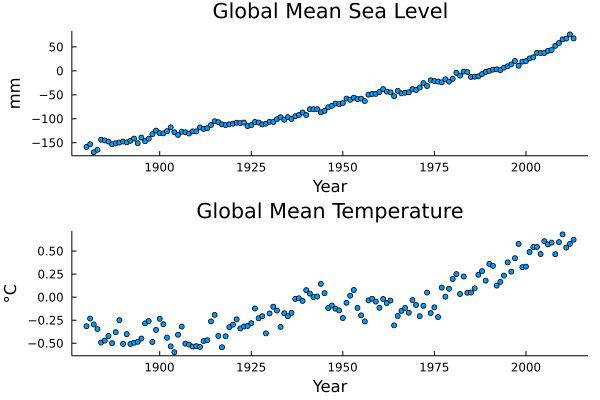

In [ ]:
#| fig-cap: "Plotted anomalies relative to 1961-1990 mean."
#| label: fig-plot-data

using Plots

# plot reconstructed anomalies as points
scatter(all_data[:, 1], Matrix(all_data[:, [2, 4]]), grid=:false, markersize=3, xlabel="Year", legend=:none, layout=(2,1), ylabel=["mm" "°C"], title=["Global Mean Sea Level" "Global Mean Temperature"])

## Fitting the Models to the Data

Now we can write functions to predict the SLR using the three [candidate models](#candidate-models).

In [11]:
#| output: false

# H_lin
function H_lin(a, b, t)
    slr_predict = a .+ (b .* (t .- t[1]))
    return slr_predict
end

# H_quad
function H_quad(a, b, c, t)
    slr_predict = a .+ (b .* (t .- t[1])) + (c .* (t .- t[1]).^2)
    return slr_predict
end

# H_emp
function H_emp(α, T₀, H₀, temp)
    temp_effect = α .* (temp .- T₀)
    slr_predict = cumsum(temp_effect) .+ H₀
    return slr_predict
end

H_emp (generic function with 1 method)

Let's also pull out the vectors of data that we will need to make our code more readable (and therefore easier to debug).

In [12]:
years = all_data[:, 1];
sealevels = all_data[:, 2];
temps = all_data[:, 4];

To find parameter values for the models, we will minimize the root-mean-square-error (RMSE):
$$\text{RMSE} = \sqrt{\sum_{t=1}^T\left(\text{pred}_t - \text{obs}_t\right)^2},$$
where $t$ is the time index, $\text{pred}_t$ is the model prediction, and $\text{obs}_t$ is the data value.

We can find parameter values which minimize the RMSE using [Optim.jl](https://julianlsolvers.github.io/Optim.jl/stable/#). The `Optim.optimize` function minimizes a function value using one of several numerical solvers. `Optim.optimize` wants its input function to accept a vector of proposed parameter values and return an output which is to be minimized. This means that we need to construct a function which accepts a parameter vector and passes the relevant values to the target function, before calculating the RMSE. This "wrapper" function is what we will want to pass to `Optim.optimize`.

We can do this using the following code. First, let's define a function for the RMSE.


In [13]:
# the mean function is in the Statistics package, not built in
using Statistics 

# y are the data, ŷ are the model predictions
rmse(y, ŷ) = sqrt(mean((y - ŷ).^2))

rmse (generic function with 1 method)

Next, we want to write our wrapper function. The function should accept a vector of parameters and the data, unpack the parameter vector and evaluate the function at those parameters, and then return the RMSE. The "tricky" part is unpacking the parameter vector. There are two approaches to this that we could take. The first is to unpack the vector manually, for example,
```julia
a, b = v
```
assigns `a = v[1]` and `b = v[2]`.

The second is more versatile, but less readable: we can use the ["splat" operator `...`](https://docs.julialang.org/en/v1/base/base/#...).^[The tradeoff between the two approaches is that the use of the splat operator is more versatile, as we don't need to know how many elements are in the vector ahead of time or their names, while manually unpacking the vectors is more readable. A good practice would be to manually unpack vectors into named variables when working with a specific function. However, in this case, we want to minimize the RMSE of three functions, and we'd have to write a different wrapper for each one given the varying number of parameters.]
This operator unpacks the elements of the vector which it acts on within a function call, so `f(v...)` gets interpreted as `f(v[1], v[2])`. This type of call can be combined with other arguments, as in:

```julia
function f(a, b, c)
   return a + b + c
end

v = [1.0, 2.0]
c = 3.0

f(v..., c)  # => f(1.0, 2.0, 3.0)
```

The last consideration is that each of `H_lin`, `H_quad`, and `H_emp` accepts an auxiliary data vector after the parameters: the time vector `t` for the first two, and temperatures `temp` for `H_emp`. This similarity means that we can write a single wrapper and pass the name of the function, the parameter vector, the auxiliary data, and the sea level data.

In [14]:
using Optim

function minimize_rmse(fn, params, aux, dat)
    # we can call the passed function
    predict = fn(params..., aux)
    return rmse(dat, predict)
end

minimize_rmse (generic function with 1 method)

The only thing left to do is to call `Optim.optimize` on `minimize_rmse` with varying functions `fn` corresponding to our three SLR models. We can deal with the constant values for each call (`fn`, `aux`, and `dat`) by using anonymous functions to map the parameter vector proposed in a given solver iteration.

In [35]:

# H_lin
# this has two uncertain parameters (a, b), so we use a 2d initial vector [0.0, 1.0]
result_lin = optimize(params -> minimize_rmse(H_lin, params, years, sealevels), [0.0, 1.0]);
params_lin = Optim.minimizer(result_lin);
@show params_lin;

params_lin = [-172.2866794430187, 1.5970719045709219]


In [36]:
# H_quad
# this has three uncertain parameters (a, b, c), so we use a 3d initial vector [0.0, 1.0, 0.0]
result_quad = optimize(params -> minimize_rmse(H_quad, params, years, sealevels), [0.0, 1.0, 0.0]);
params_quad = Optim.minimizer(result_quad);
@show params_quad;

params_quad = [-153.94760089306058, 0.7634947234485565, 0.006267398158364036]


In [37]:
# H_emp
# unlike the other two models, we pass in temperatures as the auxiliary
# this has three uncertain parameters (α, H₀, T₀), so we use a 3d initial vector [1, 0, 0]
result_emp = optimize(params -> minimize_rmse(H_emp, params, temps, sealevels), [1.0, 0.0, 0.0]);
params_emp = Optim.minimizer(result_emp);
@show params_emp;

params_emp = [1.8636596824562823, -0.9711430993147957, -157.33666238607228]


## Plotting the Fitted Models

Finally, let's plot the SLR hindcasts from all three fitted models to see how they perform.

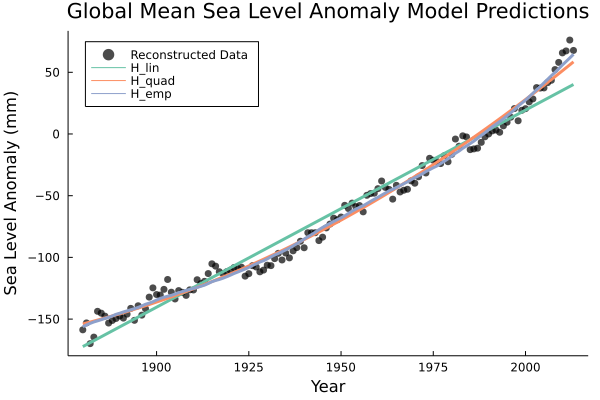

In [18]:
#| fig-cap: Outputs of the three fitted sea-level rise models vs. the reconstructed data. The reconstructed data are black dots, while the model fits are the colored lines.
#| label: fig-slr-model-fits

hindcast_lin = H_lin(params_lin..., years);
hindcast_quad = H_quad(params_quad..., years);
hindcast_emp = H_emp(params_emp..., temps);


scatter(years, sealevels, color="black", alpha=0.7, label="Reconstructed Data", legend=:topleft, grid=false, xaxis="Year", yaxis="Sea Level Anomaly (mm)", title="Global Mean Sea Level Anomaly Model Predictions")
plot!(years, hindcast_lin, color="#66c2a5", linewidth=3, label="H_lin")
plot!(years, hindcast_quad, color="#fc8d62", linewidth=3, label="H_quad")
plot!(years, hindcast_emp, color="#8da0cb", linewidth=3, label="H_emp")

We can see from @fig-slr-model-fits that the linear model $H_\text{lin}$ (green) fails to pick up the data trend at the start and end of the period (including the acceleration at the end of the data set, which makes sense), but the quadratic and semi-empirical models $H_\text{quad}$ (red) and $H_\text{emp}$ (purple) both have pretty similar outputs. 

## Selecting a Model

Comparing the RMSEs of the two models (which we can get from our optimization results using `Optim.minimum`):

In [22]:
quadratic_rmse = Optim.minimum(result_quad)
empirical_rmse = Optim.minimum(result_emp)

@show quadratic_rmse;
@show empirical_rmse;

quadratic_rmse = 6.637214473133741
empirical_rmse = 5.911184790905463


Since both of these models perform similarly, the choice between the two depends on what question you are asking. If you were primarily interested in inferring the historical temporal trend, $H_\text{quad}$ might be more useful, since it makes the time-dependence explicit, while $H_\text{emp}$ focuses on the dependence on GMT, which would be more useful for making projections given the causal link between warming and SLR.

The RMSE is slightly lower for $H_\text{emp}$, but we want to be careful to not over-interpret small differences. Visually, the main difference is that $H_\text{emp}$ shows more of an increase in the last few years, which matches what appears to be an acceleration in the data. As a result, for the rest of this section, we will use $H_\text{emp}$ for our SLR modeling, but you could justify using $H_\text{quad}$. 